<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/TslaModelExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finish Preprocess and data sequencing

In [ ]:
!pip install keras-tuner

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable GPU & Force TensorFlow to Use It
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"✅ GPU detected: {gpu_devices[0].name} (Memory Growth Enabled)")
    except:
        print("⚠️ GPU found, but could not enable memory growth.")
else:
    print("❌ No GPU detected. Running on CPU.")

# ✅ Enable Mixed Precision for Faster Training (Uses float16 on GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Enabled (float16) for Faster GPU Training")

# ✅ Check GPU Usage Before Training
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

# ✅ Function to Monitor GPU Usage Live
def monitor_gpu():
    print("\n🔍 Checking GPU Usage...")
    os.system("nvidia-smi --query-gpu=memory.used,memory.total --format=csv")

monitor_gpu()


✅ GPU detected: /physical_device:GPU:0


This code loads in the raw stock data and splits to x/y train and test sets and makes scalers for the x and y variables. The input for this is a raw.csv file

In [ ]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

# Function to detect and list valid files
def get_valid_files():
    uploaded_files = os.listdir()  # List files in Colab's working directory
    pattern = re.compile(r"^([A-Za-z]+).*raw.*\.csv$", re.IGNORECASE)  # Matches <TICKER>...raw...csv
    valid_files = {f: pattern.match(f).group(1).upper() for f in uploaded_files if pattern.match(f)}
    return valid_files

# Function to prompt user for file selection if multiple are found
def select_file():
    valid_files = get_valid_files()

    if not valid_files:
        print("❌ No valid raw stock data files found. Please upload one.")
        return None, None

    if len(valid_files) == 1:
        filename = list(valid_files.keys())[0]
        stock_ticker = valid_files[filename]
        print(f"✅ Automatically selected: {filename} ({stock_ticker})")
        return filename, stock_ticker

    # If multiple files, ask the user to select
    print("🔍 Multiple stock raw files detected. Please choose one:")
    for i, fname in enumerate(valid_files.keys()):
        print(f"{i + 1}. {fname} ({valid_files[fname]})")

    choice = int(input("Enter the number of the file to use: ")) - 1
    filename = list(valid_files.keys())[choice]
    stock_ticker = valid_files[filename]

    print(f"✅ Selected: {filename} ({stock_ticker})")
    return filename, stock_ticker

# Select file to process
file_name, ticker = select_file()

if file_name:
    # Load data
    df = pd.read_csv(file_name)

    # Drop rows with missing target values (Close Price)
    df = df.dropna(subset=['Close'])

    # Fill missing sentiment values with the last available value (forward fill)
    df[['sentiment_polarity', 'sentiment_subjectivity']] = df[['sentiment_polarity', 'sentiment_subjectivity']].ffill()

    # Drop any remaining NaN values
    df = df.dropna()

    # Convert Date to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # Select relevant features
    features = ['Open', 'High', 'Low', 'Volume', 'ATR', 'BB_High', 'BB_low', 'DC_High', 'DC_low',
                'KC_High', 'KC_Low', 'Williams_%R', 'sentiment_polarity', 'sentiment_subjectivity']
    target = ['Close']

    # Scaling
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_x.fit_transform(df[features])
    y_scaled = scaler_y.fit_transform(df[target])

    # Convert to sequences for LSTM/CNN
    sequence_length = 30
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i+sequence_length])
        y_seq.append(y_scaled[i+sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    # Save scalers (Colab sidebar)
    joblib.dump(scaler_x, "scaler_x.pkl")
    joblib.dump(scaler_y, "scaler_y.pkl")

    # Save processed data
    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)

    print(f"✅ Preprocessing complete for {ticker}. Files saved:")
    print("- X_train.npy, X_test.npy, y_train.npy, y_test.npy")
    print("- scaler_x.pkl, scaler_y.pkl")
else:
    print("❌ No valid file selected. Exiting.")


✅ Automatically selected: TSLAraw.csv (TSLA)
✅ Preprocessing complete for TSLA. Files saved:
- X_train.npy, X_test.npy, y_train.npy, y_test.npy
- scaler_x.pkl, scaler_y.pkl


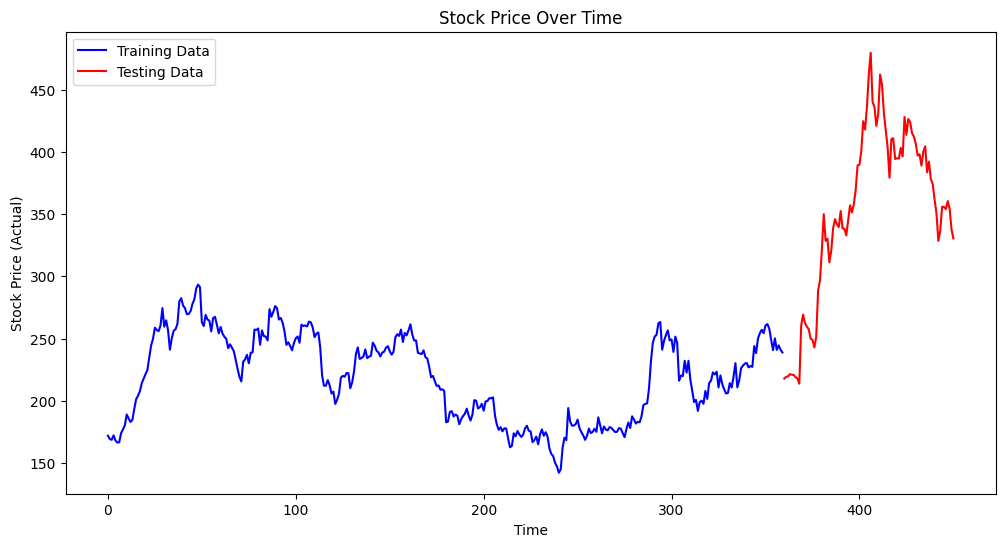

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load preprocessed data from Colab sidebar
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Load scalers
scaler_y = joblib.load("scaler_y.pkl")

# Unscale target values (stock prices)
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# Plot actual stock price vs time
plt.figure(figsize=(12,6))
plt.plot(y_train_unscaled, label="Training Data", color="blue")
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_test_unscaled)), y_test_unscaled, label="Testing Data", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()


# RNN

This RNN model is designed for multi-step stock price forecasting, predicting three future time steps using a deep architecture with three stacked SimpleRNN layers. It employs Bayesian hyperparameter tuning to optimize the number of RNN units, dropout rates, dense layer size, and learning rate, aiming to enhance prediction accuracy over multiple future days.

✅ Data Loaded: X_train shape: (360, 30, 14), y_train shape: (360, 1)
✅ X_test shape: (91, 30, 14), y_test shape: (91, 1)
✅ New y_train shape: (357, 3), y_test shape: (88, 3)
Reloading Tuner from rnn1/tuning/stock_forecasting/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Best hyperparameters saved in rnn1!
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 275ms/step - loss: 0.1554 - mae: 0.3031 - val_loss: 0.1020 - val_mae: 0.2800
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0406 - mae: 0.1593 - val_loss: 0.1016 - val_mae: 0.2797
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0313 - mae: 0.1402 - val_loss: 0.1340 - val_mae: 0.3327
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - mae: 0.1068 - val_loss: 0.1265 - val_mae: 0.3236
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mae: 0.0977 - val_loss: 0.1181 - val_mae: 0.3129
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - mae: 0.0858 - val_loss: 0.1136 - val_mae: 0.3047
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - mae: 0.0872 - val_loss: 0.1202 - val_mae: 0.3121
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - mae: 0.0753 - val_loss: 0.1181 - val_mae: 0.3083
Epoch 9/100
23/2

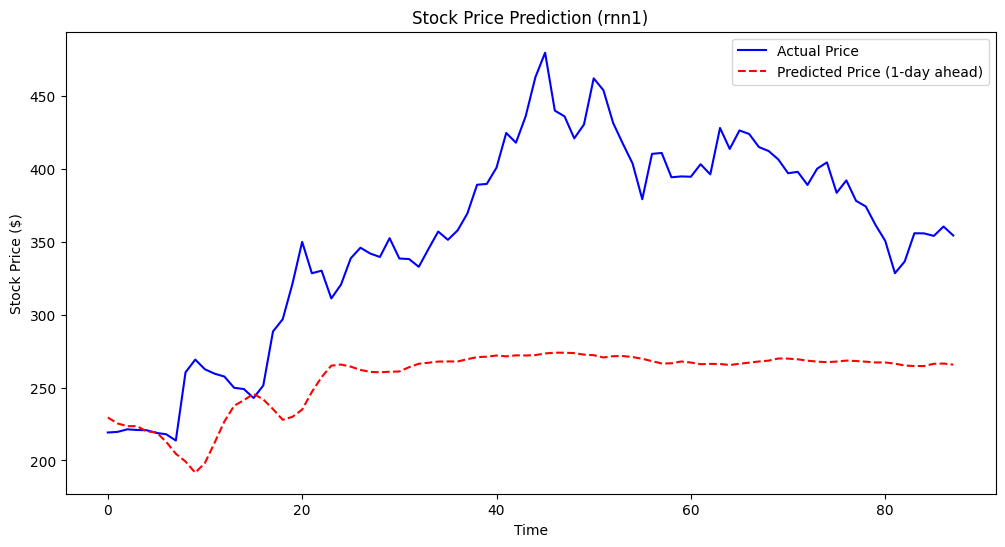


🎯 rnn1 Model Training & Prediction Complete! 🚀


In [ ]:
#MultiStep RNN
import os
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import joblib
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === Define Model Save Path ===
rnn_folder = "rnn1"  # Change to rnn2, rnn3, etc. for future models
os.makedirs(rnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Create Multi-Step Target ===
FUTURE_STEPS = 3  # Number of days ahead to predict

def create_future_labels(y, future_steps):
    y_future = np.zeros((y.shape[0] - future_steps, future_steps))
    for i in range(y_future.shape[0]):
        y_future[i] = y[i + 1: i + 1 + future_steps].flatten()
    return y_future

y_train_future = create_future_labels(y_train, FUTURE_STEPS)
y_test_future = create_future_labels(y_test, FUTURE_STEPS)
X_train = X_train[:y_train_future.shape[0]]
X_test = X_test[:y_test_future.shape[0]]

print(f"✅ New y_train shape: {y_train_future.shape}, y_test shape: {y_test_future.shape}")

# === Step 3: Define RNN Model for Hyperparameter Tuning ===
def build_rnn_model(hp):
    model = Sequential([
        SimpleRNN(
            units=hp.Int('rnn_units_1', min_value=50, max_value=150, step=25),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)),

        SimpleRNN(
            units=hp.Int('rnn_units_2', min_value=50, max_value=150, step=25),
            return_sequences=True
        ),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)),

        SimpleRNN(
            units=hp.Int('rnn_units_3', min_value=50, max_value=150, step=25)
        ),
        Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.4, step=0.1)),

        Dense(units=hp.Int('dense_units', min_value=10, max_value=50, step=10), activation="relu"),
        Dense(units=FUTURE_STEPS)
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# === Step 4: Initialize Bayesian Hyperparameter Tuner ===
tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective="val_loss",
    max_trials=20,
    directory=os.path.join(rnn_folder, "tuning"),
    project_name="stock_forecasting"
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train_future, epochs=50, validation_data=(X_test, y_test_future))

# Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# ✅ Save Best Hyperparameters in rnnX folder
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(rnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {rnn_folder}!")

# === Step 5: Train the Best Model ===
BATCH_SIZE = 16
history = best_model.fit(
    X_train, y_train_future,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test_future),
    verbose=1
)

# ✅ Save the Best Model in rnnX folder
best_model.save(os.path.join(rnn_folder, "best_rnn_model.keras"))
print(f"✅ Best RNN Model saved in {rnn_folder}!")

# === Step 6: Make Multi-Step Predictions ===
predictions = best_model.predict(X_test)

# === Step 7: Reverse Scale Predictions and Actual Values ===
def inverse_transform_multi_feature(scaler, data):
    """Properly inverse transform predictions to their actual stock price scale."""
    data = np.array(data).reshape(-1, 1)  # Reshape for transformation
    return scaler.inverse_transform(data)

# ✅ Unscale Predictions and Actual Prices
predictions_rescaled = inverse_transform_multi_feature(scaler_y, predictions[:, 0])
y_test_rescaled = inverse_transform_multi_feature(scaler_y, y_test_future[:, 0])

# === Step 8: Plot Multi-Step Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price (1-day ahead)", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({rnn_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

print(f"\n🎯 {rnn_folder} Model Training & Prediction Complete! 🚀")


This RNN model is optimized for single-step stock price prediction, using two SimpleRNN layers with tunable hyperparameters and a more extensive search space. It incorporates random search for hyperparameter tuning, early stopping for training efficiency, and saves the best model configuration for reproducibility.

Trial 10 Complete [00h 00m 26s]
val_loss: 0.06071772240102291

Best val_loss So Far: 0.015920131001621485
Total elapsed time: 00h 04m 26s
✅ Best hyperparameters saved in rnn2!
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0793 - mae: 0.2231 - val_loss: 0.3164 - val_mae: 0.4873
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0271 - mae: 0.1345 - val_loss: 0.3182 - val_mae: 0.4855
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - mae: 0.1190 - val_loss: 0.2666 - val_mae: 0.4438
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0211 - mae: 0.1116 - val_loss: 0.2172 - val_mae: 0.3949
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0197 - mae: 0.1105 - val_loss: 0.1904 - val_mae: 0.3693
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - mae: 0.1008 - val_loss: 0.1757 - val_mae: 0.3642
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.0883 - val_loss: 0.1536 - val_mae: 0.3364
Epo

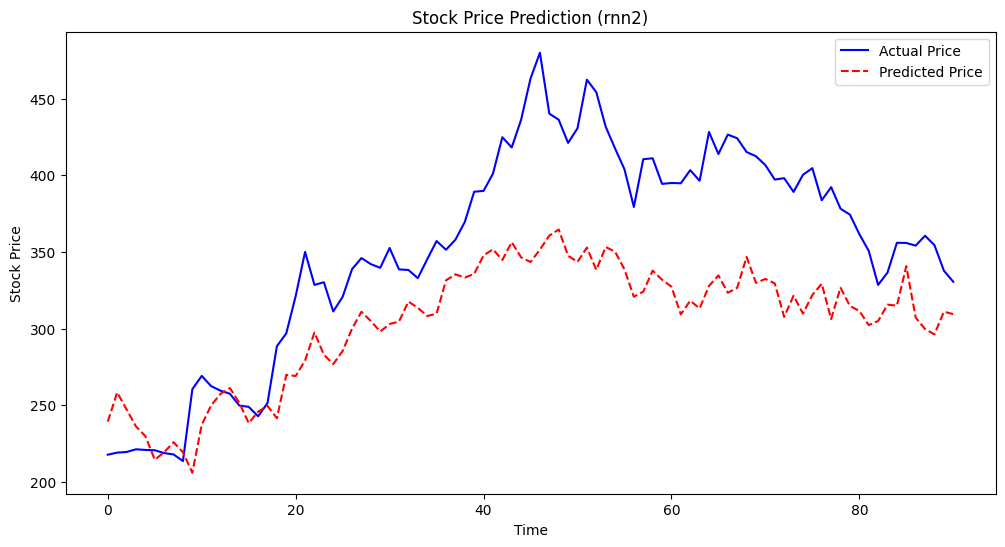


🎯 rnn2 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
rnn_folder = "rnn2"  # Change to rnn3, rnn4, etc. for future models
os.makedirs(rnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_rnn_model(hp):
    """Builds an improved RNN model with tunable hyperparameters."""
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  # ✅ Fixed Input Layer

        # First RNN Layer
        SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125, 150]), return_sequences=True),
        Dropout(hp.Choice('dropout_rate', [0.05, 0.1, 0.2])),

        # Second RNN Layer
        SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125, 150])),
        Dropout(hp.Choice('dropout_rate_2', [0.05, 0.1, 0.2])),

        # Fully Connected Layers
        Dense(units=50, activation="relu"),
        Dense(units=1)
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )

    return model

# ✅ Run More Trials
tuner = kt.RandomSearch(
    build_rnn_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=2,
    directory=os.path.join(rnn_folder, "tuning"),
    project_name="stock_prediction_tuned"
)

# ✅ Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters in `rnn2/`
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(rnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {rnn_folder}!")

# === Step 3: Train the Best Model with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model in `rnn2/`
best_model.save(os.path.join(rnn_folder, "best_rnn_model.keras"))
print(f"✅ Best RNN Model saved in {rnn_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """
    Properly inverse transforms a single feature using the original scaler.
    Ensures that only the Close Price is inverse transformed.
    """
    data = np.array(data).reshape(-1, 1)  # Reshape for transformation
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({rnn_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {rnn_folder} Model Training & Prediction Complete! 🚀")


This RNN model employs three stacked SimpleRNN layers with Bayesian optimization to fine-tune hyperparameters, focusing on single-step stock price prediction. It improves hyperparameter saving, ensures correct batch size usage, and correctly rescales predictions using a modified inverse transformation method for accurate stock price reconstruction.

Trial 10 Complete [00h 00m 16s]
val_loss: 0.03903677314519882

Best val_loss So Far: 0.03403773531317711
Total elapsed time: 00h 05m 12s
✅ Best hyperparameters saved in rnn3!
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.2832 - mae: 0.4363 - val_loss: 0.2841 - val_mae: 0.4910
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1668 - mae: 0.3203 - val_loss: 0.2988 - val_mae: 0.4986
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1567 - mae: 0.3173 - val_loss: 0.2502 - val_mae: 0.4407
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0960 - mae: 0.2388 - val_loss: 0.2109 - val_mae: 0.3988
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0924 - mae: 0.2394 - val_loss: 0.2250 - val_mae: 0.4125
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0729 - mae: 0.2226 - val_loss: 0.2068 - val_mae: 0.3958
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - mae: 0.2307 - val_loss: 0.1615 - val_mae: 0.35

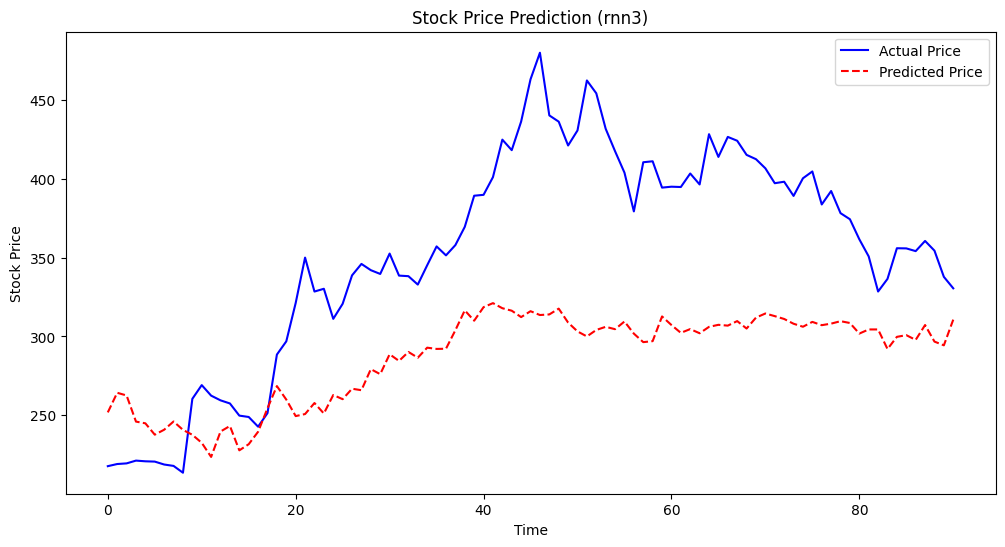


🎯 rnn3 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
rnn_folder = "rnn3"  # Change to rnn4, rnn5, etc. for future models
os.makedirs(rnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_rnn_model(hp):
    """Builds an RNN model with tunable hyperparameters."""
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  # ✅ Fixed Input Layer

        # First RNN Layer
        SimpleRNN(units=hp.Choice('rnn_units_1', [50, 75, 100]), return_sequences=True),
        Dropout(hp.Choice('dropout_rate_1', [0.1, 0.2, 0.3])),

        # Second RNN Layer
        SimpleRNN(units=hp.Choice('rnn_units_2', [50, 75, 100]), return_sequences=True),
        Dropout(hp.Choice('dropout_rate_2', [0.1, 0.2, 0.3])),

        # Third RNN Layer
        SimpleRNN(units=hp.Choice('rnn_units_3', [50, 75, 100])),
        Dropout(hp.Choice('dropout_rate_3', [0.1, 0.2, 0.3])),

        # Fully Connected Layers
        Dense(units=25, activation="relu"),
        Dense(units=1)
    ])

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )

    return model

# Initialize Hyperparameter Tuner
tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective="val_loss",
    max_trials=10,
    directory=os.path.join(rnn_folder, "tuning"),
    project_name="stock_prediction"
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Get Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# ✅ Save Best Hyperparameters in `rnn3/`
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(rnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {rnn_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 16

# === Step 3: Train the Best Model with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model in `rnn3/`
best_model.save(os.path.join(rnn_folder, "best_rnn_model.keras"))
print(f"✅ Best RNN Model saved in {rnn_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """
    Properly inverse transforms a single feature using the original scaler.
    Ensures that only the Close Price is inverse transformed.
    """
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({rnn_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {rnn_folder} Model Training & Prediction Complete! 🚀")


# CNN

This CNN model consists of three Conv1D layers with tunable filter sizes, kernel sizes, and dropout rates, followed by MaxPooling1D for downsampling. It uses a single fully connected Dense layer before the output layer, optimizing hyperparameters via RandomSearch. The model focuses on efficient feature extraction but lacks batch normalization, which could impact stability and training efficiency.



Trial 15 Complete [00h 00m 28s]
val_loss: 0.0744117721915245

Best val_loss So Far: 0.03137282934039831
Total elapsed time: 00h 06m 30s
✅ Building Model...
✅ Shape before second Conv layer: (None, 29, 128)
✅ Shape before third Conv layer: (None, 28, 128)
✅ Best hyperparameters saved in cnn1!
Epoch 1/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0152 - mae: 0.0994 - val_loss: 0.0826 - val_mae: 0.2558
Epoch 2/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mae: 0.0567 - val_loss: 0.0705 - val_mae: 0.2387
Epoch 3/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0563 - val_mae: 0.2046
Epoch 4/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0472 - val_loss: 0.0618 - val_mae: 0.2175
Epoch 5/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0685 - val_mae: 0.2265
Epoch 6/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0464 - val_loss: 0.0496 - val_mae: 0.1830
Epo

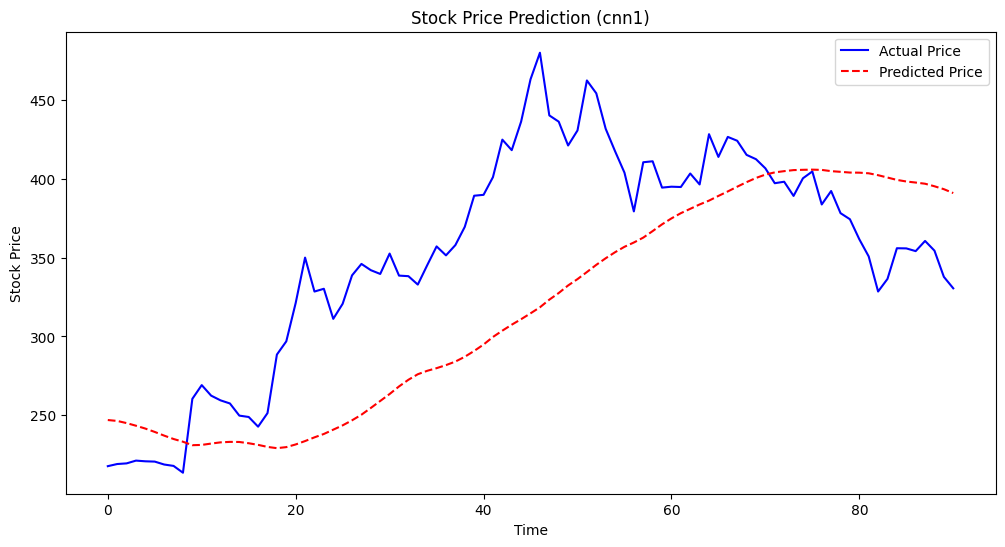


🎯 cnn1 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import shutil  # ✅ To delete old tuner files
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
cnn_folder = "cnn1"
os.makedirs(cnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ✅ Ensure input shape is correct
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"✅ Model Input Shape: {input_shape}")

# === Step 2: Hyperparameter Tuning ===
def build_cnn_model(hp):
    """Builds an improved CNN model with tunable hyperparameters."""
    print("✅ Building Model...")  # ✅ Debugging: Model building step

    model = Sequential()
    model.add(Input(shape=input_shape))

    # First Convolutional Layer
    filters_1 = hp.Choice('filters_1', [32, 64, 128])
    kernel_size_1 = hp.Int("kernel_size_1", min_value=2, max_value=5, step=1)
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="same"))
    model.add(Dropout(hp.Choice('dropout_rate_1', [0.1, 0.2])))

    # ✅ Debugging: Print shape before the next layer
    print(f"✅ Shape before second Conv layer: (None, {X_train.shape[1]-1}, {filters_1})")

    # Second Convolutional Layer
    filters_2 = hp.Choice('filters_2', [32, 64, 128])
    kernel_size_2 = hp.Int("kernel_size_2", min_value=2, max_value=5, step=1)
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="same"))
    model.add(Dropout(hp.Choice('dropout_rate_2', [0.1, 0.2])))

    # ✅ Debugging: Print shape before the next layer
    print(f"✅ Shape before third Conv layer: (None, {X_train.shape[1]-2}, {filters_2})")

    # Third Convolutional Layer
    filters_3 = hp.Choice('filters_3', [32, 64, 128])
    kernel_size_3 = hp.Int("kernel_size_3", min_value=2, max_value=5, step=1)
    model.add(Conv1D(filters=filters_3, kernel_size=kernel_size_3, activation='relu'))

    # Instead of excessive pooling, use GlobalAveragePooling1D
    model.add(GlobalAveragePooling1D())

    # Dense Layers
    dense_units_1 = hp.Choice('dense_units_1', [64, 128, 256])
    model.add(Dense(units=dense_units_1, activation="relu"))
    model.add(Dropout(hp.Choice('dropout_rate_dense', [0.1, 0.2])))

    # Output Layer
    model.add(Dense(units=1))

    # Compile Model
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse", metrics=["mae"])

    return model  # ✅ Ensure model is returned properly

# ✅ Delete old tuner files to avoid corrupted checkpoints
tuner_dir = os.path.join(cnn_folder, "tuning")
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)
    print("✅ Old tuner files deleted. Restarting search...")

# ✅ Initialize Tuner
tuner = kt.RandomSearch(
    build_cnn_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=2,
    directory=tuner_dir,
    project_name="stock_prediction_tuned"
)

# ✅ Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=40, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Build Best Model
best_model = tuner.hypermodel.build(best_hps)  # 🔹 FIXED: Ensure best_model is built before training

# ✅ Save Best Hyperparameters in `cnn1/`
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(cnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {cnn_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 16

# === Step 3: Train the Best Model with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model in `cnn1/`
best_model.save(os.path.join(cnn_folder, "best_cnn_model.keras"))
print(f"✅ Best CNN Model saved in {cnn_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({cnn_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {cnn_folder} Model Training & Prediction Complete! 🚀")


This enhanced CNN model builds on cnn1 by adding BatchNormalization after each convolutional layer, helping to stabilize training and improve generalization. It also includes an extra dense layer for deeper feature extraction and increases both the batch size and hyperparameter tuning trials for better performance. The longer training time and additional layers make it more robust for capturing complex stock price patterns compared to cnn1.

Trial 20 Complete [00h 01m 00s]
val_loss: 0.08808900664250056

Best val_loss So Far: 0.06644457578659058
Total elapsed time: 00h 18m 17s
✅ Best hyperparameters saved in cnn2!
Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 371ms/step - loss: 1.3344 - mae: 0.9024 - val_loss: 0.3864 - val_mae: 0.5856
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9448 - mae: 0.7788 - val_loss: 0.3575 - val_mae: 0.5558
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1393 - mae: 0.8385 - val_loss: 0.3271 - val_mae: 0.5311
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0070 - mae: 0.8134 - val_loss: 0.2741 - val_mae: 0.4867
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0123 - mae: 0.7717 - val_loss: 0.2303 - val_mae: 0.4437
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7451 - mae: 0.6827 - val_loss: 0.2335 - val_mae: 0.4460
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8110 - mae: 0.7000 - val_loss: 0.2196 - val_mae: 0.4312
Epo

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


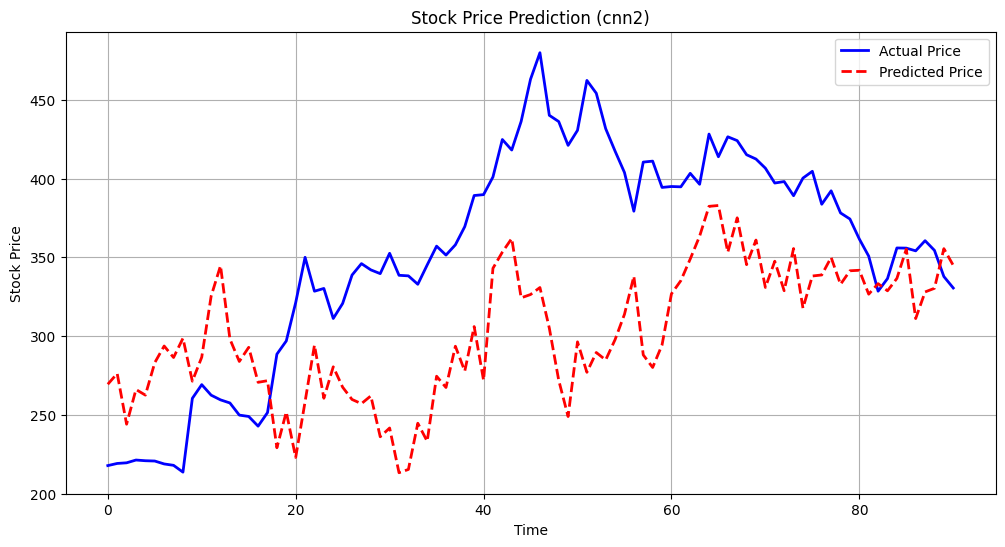


🎯 cnn2 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
cnn_folder = "cnn2"
os.makedirs(cnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Maximum valid kernel size based on sequence length
MAX_KERNEL_SIZE = min(X_train.shape[1] // 2, 5)

# === Step 2: Hyperparameter Tuning ===
def build_cnn_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters=hp.Choice('filters_1', [64, 128, 256]),
               kernel_size=hp.Choice('kernel_size_1', [3, MAX_KERNEL_SIZE]),
               activation='relu', padding="same"),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Dropout(hp.Choice('dropout_rate_1', [0.1, 0.2, 0.3])),
        Conv1D(filters=hp.Choice('filters_2', [64, 128, 256]),
               kernel_size=hp.Choice('kernel_size_2', [3, min(MAX_KERNEL_SIZE, 4)]),
               activation='relu', padding="same"),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Dropout(hp.Choice('dropout_rate_2', [0.1, 0.2, 0.3])),
        Conv1D(filters=hp.Choice('filters_3', [64, 128, 256]),
               kernel_size=hp.Choice('kernel_size_3', [3, min(MAX_KERNEL_SIZE, 3)]),
               activation='relu', padding="same"),
        MaxPooling1D(pool_size=2, padding="same"),
        BatchNormalization(),
        Dropout(hp.Choice('dropout_rate_3', [0.1, 0.2, 0.3])),
        Flatten(),
        Dense(units=hp.Choice('dense_units_1', [128, 256, 512]), activation="relu"),
        Dropout(hp.Choice('dropout_rate_dense_1', [0.1, 0.2])),
        Dense(units=hp.Choice('dense_units_2', [64, 128, 256]), activation="relu"),
        Dropout(hp.Choice('dropout_rate_dense_2', [0.1, 0.2])),
        Dense(units=1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Hyperparameter tuning

# ✅ Run More Trials for Better Tuning
tuner = kt.RandomSearch(
    build_cnn_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=3,
    directory=os.path.join(cnn_folder, "tuning"),
    project_name="stock_prediction_tuned"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(cnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {cnn_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 32

# Train the model with best hyperparameters
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(cnn_folder, "best_cnn_model.keras"))
print(f"✅ Best CNN Model saved in {cnn_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Ensures data is correctly reshaped before inverse transformation."""
    if len(data.shape) == 1:  # If it's a flat array, reshape it
        data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).flatten()  # Flatten after inverse transform

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions.squeeze())
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test.squeeze())

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue", linewidth=2)
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed", linewidth=2)
plt.title(f"Stock Price Prediction ({cnn_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

print(f"\n🎯 {cnn_folder} Model Training & Prediction Complete! 🚀")


#Arima Model

✅ Data Loaded: y_train shape: (360,), y_test shape: (91,)
📉 ADF Test Statistic: -2.1985, p-value: 0.2068
⚠️ Data is NOT stationary. Applying differencing (d=1)...
🔍 Searching for the best (p, d, q) parameters using Grid Search...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ New Best ARIMA(0, 0, 0) with MSE: 0.0020
✅ New Best ARIMA(0, 0, 1) with MSE: 0.0020
✅ New Best ARIMA(0, 1, 1) with MSE: 0.0020
✅ New Best ARIMA(0, 1, 2) with MSE: 0.0020


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ New Best ARIMA(1, 1, 1) with MSE: 0.0020


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels

✅ New Best ARIMA(2, 1, 3) with MSE: 0.0019


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py

🏆 Best ARIMA Hyperparameters: {'p': 2, 'd': 1, 'q': 3}
✅ Best hyperparameters saved in arima1!
🚀 Training Best ARIMA(2, 1, 3) Model...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Best ARIMA Model saved in arima1!
✅ ARIMA Model MAE: 110.4376, MSE: 15695.1264


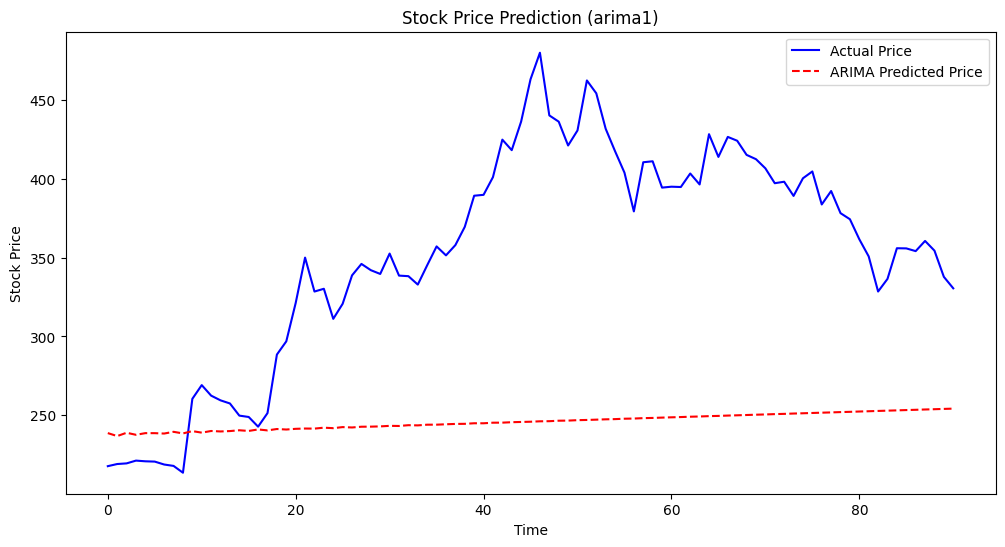

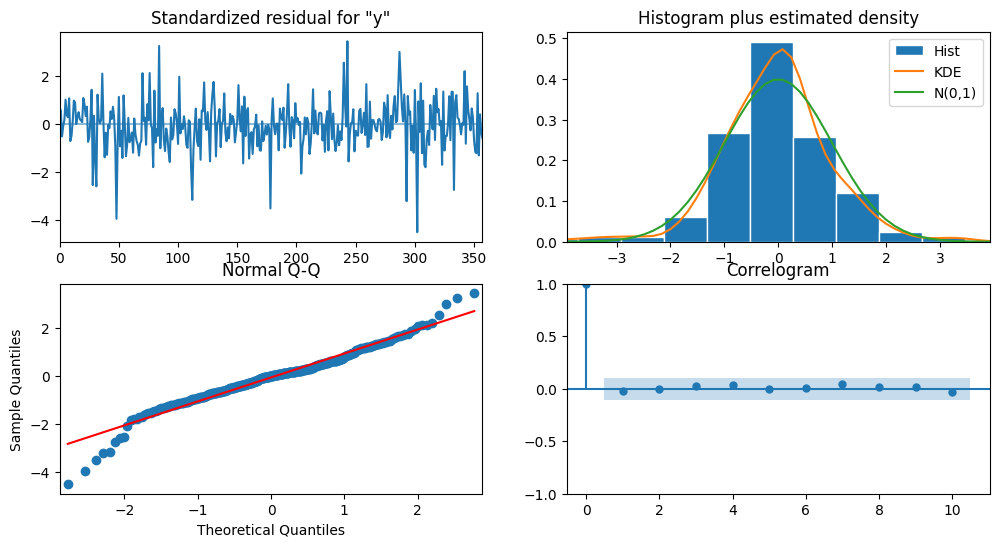


🎯 arima1 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import joblib
import json
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Define Model Save Path ===
arima_folder = "arima1"
os.makedirs(arima_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
y_train = np.load("y_train.npy").flatten()
y_test = np.load("y_test.npy").flatten()

# Load Scaler
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# === Step 2: Check & Ensure Stationarity ===
def check_stationarity(timeseries):
    """Performs the Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(timeseries)
    print(f"📉 ADF Test Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05  # If p-value < 0.05, data is stationary

# Apply differencing if necessary
if not check_stationarity(y_train):
    print("⚠️ Data is NOT stationary. Applying differencing (d=1)...")
    y_train_diff = np.diff(y_train)  # First-order differencing
    y_test_diff = np.diff(y_test)
    differenced = True
else:
    print("✅ Data is already stationary. No differencing needed.")
    y_train_diff, y_test_diff = y_train, y_test
    differenced = False

# === Step 3: Hyperparameter Tuning with Expanded Grid Search ===
print("🔍 Searching for the best (p, d, q) parameters using Grid Search...")

p_values = range(0, 4)
d_values = range(0, 2)  # Keep d small
q_values = range(0, 4)

best_score, best_cfg = float("inf"), None

# Grid Search for Best (p, d, q)
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(y_train_diff, order=(p, d, q))
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(y_test_diff))
        mse = mean_squared_error(y_test_diff, predictions)

        if mse < best_score:
            best_score, best_cfg = mse, (p, d, q)
            print(f"✅ New Best ARIMA({p}, {d}, {q}) with MSE: {mse:.4f}")

    except Exception as e:
        print(f"⚠️ Skipping ARIMA({p}, {d}, {q}) due to error: {e}")
        continue

best_p, best_d, best_q = best_cfg
best_hps = {"p": best_p, "d": best_d, "q": best_q}
print(f"🏆 Best ARIMA Hyperparameters: {best_hps}")

# ✅ Save Best Hyperparameters
with open(os.path.join(arima_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps, f)
print(f"✅ Best hyperparameters saved in {arima_folder}!")

# === Step 4: Train the Best ARIMA Model ===
print(f"🚀 Training Best ARIMA({best_p}, {best_d}, {best_q}) Model...")
arima_model = ARIMA(y_train_diff, order=(best_p, best_d, best_q))
arima_fit = arima_model.fit()

# ✅ Save the Best Model
joblib.dump(arima_fit, os.path.join(arima_folder, "best_arima_model.pkl"))
print(f"✅ Best ARIMA Model saved in {arima_folder}!")

# === Step 5: Make Predictions ===
arima_predictions = arima_fit.forecast(steps=len(y_test_diff))

# === Step 6: Properly Reverse Differencing ===
def reverse_differencing(predictions, original_series):
    """Restores original price levels after differencing."""
    if differenced:
        return np.r_[original_series[-1], predictions].cumsum()
    return predictions

arima_predictions_restored = reverse_differencing(arima_predictions, y_train)

# === Step 7: Correctly Reverse Scale Predictions ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data).flatten()

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, arima_predictions_restored)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)  # Fix test set scaling

# === Step 8: Ensure Matching Lengths ===
min_length = min(len(y_test_rescaled), len(predictions_rescaled))
y_test_rescaled = y_test_rescaled[:min_length]
predictions_rescaled = predictions_rescaled[:min_length]

# === Step 9: Evaluate Performance ===
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"✅ ARIMA Model MAE: {mae:.4f}, MSE: {mse:.4f}")

# === Step 10: Plot ARIMA Predictions vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="ARIMA Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({arima_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# === Step 11: ARIMA Diagnostics Plot ===
arima_fit.plot_diagnostics(figsize=(12, 6))
plt.show()

print(f"\n🎯 {arima_folder} Model Training & Prediction Complete! 🚀")


#LSTM

LSTM1 is a standard two-layer LSTM model designed to capture sequential stock price patterns. It includes a single dense layer for feature extraction and dropout for regularization. This model serves as the baseline for performance comparisons with more advanced architectures.

Trial 10 Complete [00h 00m 19s]
val_loss: 0.015066985040903091

Best val_loss So Far: 0.015066985040903091
Total elapsed time: 00h 03m 11s
✅ Best hyperparameters saved in lstm1!
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0358 - val_mae: 0.1676
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0436 - val_loss: 0.0321 - val_mae: 0.1576
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0177 - val_mae: 0.1112
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - mae: 0.0391 - val_loss: 0.0342 - val_mae: 0.1617
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0342 - val_loss: 0.0316 - val_mae: 0.1551
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0333 - val_loss: 0.0380 - val_mae: 0.1706
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - mae: 0.0365 - val_loss: 0.0316 - val_mae: 0.1539
Ep

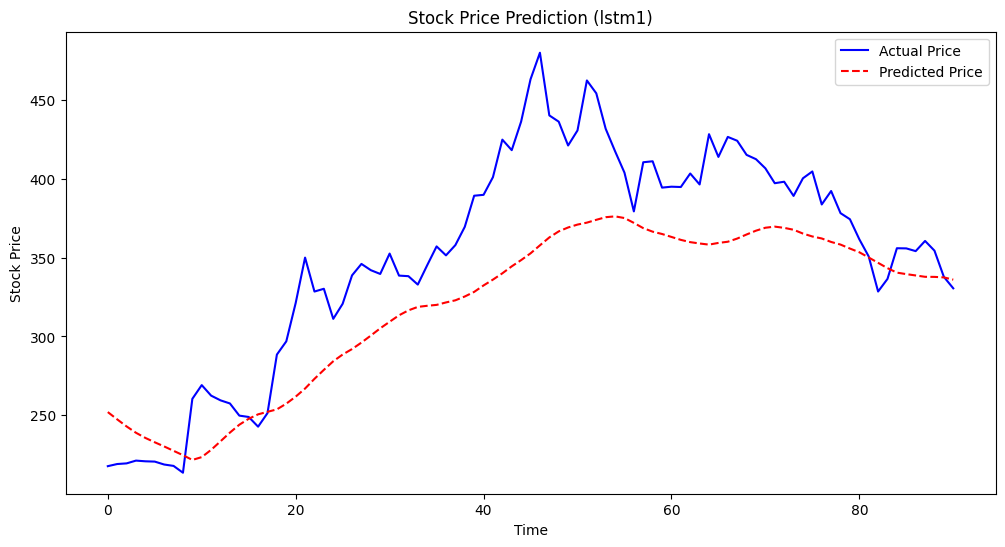


🎯 lstm1 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
lstm_folder = "lstm1"
os.makedirs(lstm_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_lstm_model(hp):
    """Builds an LSTM model."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # LSTM Layers
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

    # Fully Connected Layers
    dense = Dense(50, activation="relu")(lstm)
    dense = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(dense)

    # Output Layer
    output = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=2,
    directory=os.path.join(lstm_folder, "tuning"),
    project_name="stock_prediction"
)

tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

# ✅ Save Best Hyperparameters in `lstm1/`
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(lstm_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {lstm_folder}!")

# === Step 3: Train the Best Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model in `lstm1/`
best_model.save(os.path.join(lstm_folder, "best_lstm_model.keras"))
print(f"✅ Best LSTM Model saved in {lstm_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({lstm_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {lstm_folder} Model Training & Prediction Complete! 🚀")


LSTM2 enhances the baseline by using Bidirectional LSTMs, allowing it to learn patterns in both forward and backward directions. It also introduces batch normalization for stabilized training and an additional dense layer for better feature extraction. This model aims to reduce error and improve predictive accuracy over LSTM1.

Trial 20 Complete [00h 01m 26s]
val_loss: 0.22388198102513948

Best val_loss So Far: 0.0218858706454436
Total elapsed time: 00h 26m 10s
Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.6965 - mae: 1.0229 - val_loss: 0.2313 - val_mae: 0.4485
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8326 - mae: 0.7461 - val_loss: 0.4528 - val_mae: 0.6293
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6033 - mae: 0.6249 - val_loss: 0.0919 - val_mae: 0.2727
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5931 - mae: 0.6138 - val_loss: 0.1918 - val_mae: 0.3998
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4072 - mae: 0.5116 - val_loss: 0.2760 - val_mae: 0.4904
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3492 - mae: 0.4778 - val_loss: 0.2519 - val_mae: 0.4858
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2905 - mae: 0.4186 - val_loss: 0.1373 - val_mae: 0.3166
Epoch 8/300
23/23 ━━━━━━━━━━━━━━━━━━━━

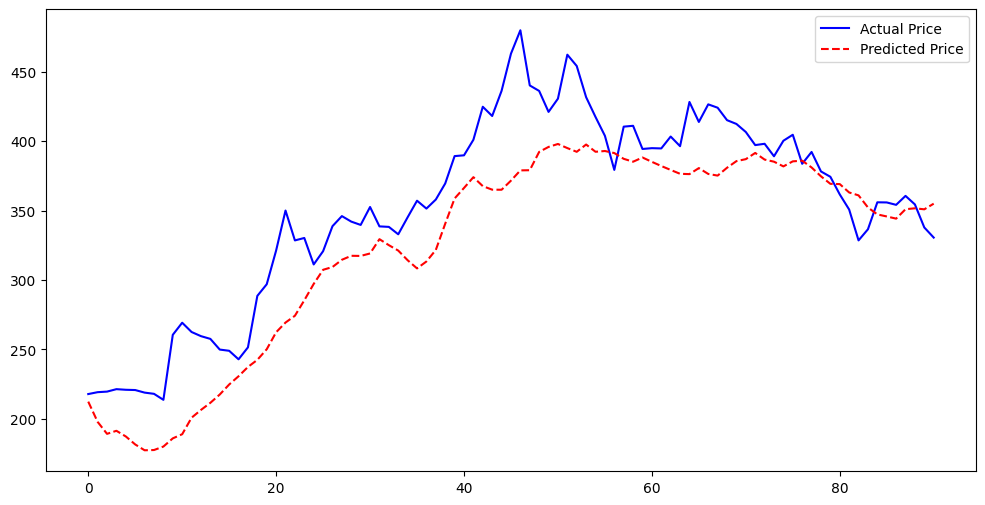

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import shutil  # ✅ For deleting old tuner files
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
lstm_folder = "lstm2_fixed"
os.makedirs(lstm_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

# ✅ Print data shape for debugging
print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# ✅ Ensure X_train is 3D
if len(X_train.shape) != 3:
    raise ValueError(f"❌ X_train should have 3 dimensions (samples, timesteps, features), but got {X_train.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_lstm_model(hp):
    """Builds an improved LSTM model with better tuning."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # First LSTM Layer
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_1', [100, 150, 200]), return_sequences=True))(inputs)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_1', [0.1, 0.2]))(lstm)

    # Second LSTM Layer
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_2', [100, 150, 200]), return_sequences=True))(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_2', [0.1, 0.2]))(lstm)

    # Third LSTM Layer
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_3', [100, 150, 200])))(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_3', [0.1, 0.2]))(lstm)

    # Fully Connected Layers
    dense = Dense(units=hp.Choice('dense_units_1', [128, 256]), activation="relu")(lstm)
    dense = Dropout(hp.Choice('dropout_rate_dense', [0.1, 0.2]))(dense)

    # Output Layer
    output = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.0001, 0.00005])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Delete old tuner files before running
tuner_dir = os.path.join(lstm_folder, "tuning")
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)
    print("✅ Old tuner files deleted. Restarting hyperparameter tuning...")

# ✅ Initialize Tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=20,  # More trials for better tuning
    executions_per_trial=3,  # More executions for stability
    directory=tuner_dir,
    project_name="stock_prediction"
)

# ✅ Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps_list = tuner.get_best_hyperparameters(num_trials=1)
if not best_hps_list:
    raise RuntimeError("❌ No best hyperparameters found. Check if the tuner ran successfully.")
best_hps = best_hps_list[0]

# ✅ Set Batch Size
BATCH_SIZE = 16

# === Step 3: Train the Best Model with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(lstm_folder, "best_lstm_model.keras"))

# ✅ Ensure no NaN values in predictions
predictions = best_model.predict(X_test)
if np.isnan(predictions).any():
    predictions = np.nan_to_num(predictions, nan=np.nanmean(predictions))

# === Reverse Scale Predictions ===
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# === Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.legend()
plt.show()


LSTM3 (Advanced Deep Learning LSTM Model)
LSTM3 expands upon LSTM2 by adding more LSTM layers and increasing the number of neurons per layer to capture deeper sequential dependencies. It also incorporates a learning rate scheduler for optimized convergence and higher dropout rates to prevent overfitting. This model is designed for maximum predictive accuracy and robustness.

Trial 20 Complete [00h 01m 37s]
val_loss: 0.17822134991486868

Best val_loss So Far: 0.10528634985287984
Total elapsed time: 00h 30m 47s
✅ Best hyperparameters saved in lstm3!
Epoch 1/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.9930 - mae: 0.7842 - val_loss: 0.4874 - val_mae: 0.6674 - learning_rate: 1.0000e-04
Epoch 2/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9842 - mae: 0.7901 - val_loss: 0.4658 - val_mae: 0.6537 - learning_rate: 1.0000e-04
Epoch 3/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8308 - mae: 0.7074 - val_loss: 0.4992 - val_mae: 0.6794 - learning_rate: 1.0000e-04
Epoch 4/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9430 - mae: 0.7432 - val_loss: 0.5430 - val_mae: 0.7102 - learning_rate: 1.0000e-04
Epoch 5/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7496 - mae: 0.7024 - val_loss: 0.5414 - val_mae: 0.7102 - learning_rate: 1.0000e-04
Epoch 6/350
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9404 - mae: 0.7450 - val_loss: 0

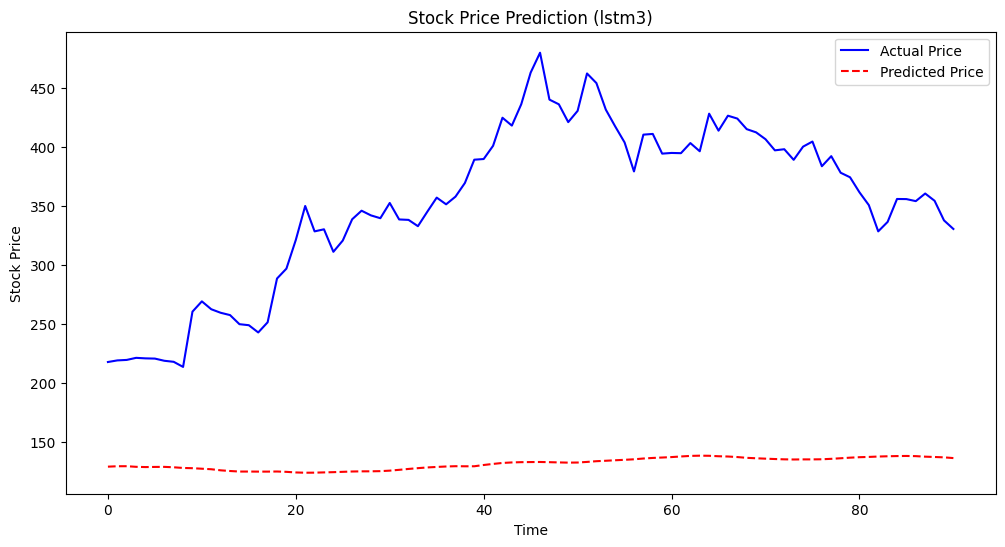


🎯 lstm3 Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Define Model Save Path ===
lstm_folder = "lstm3"
os.makedirs(lstm_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_lstm_model(hp):
    """Builds an advanced LSTM model with deeper layers and a learning rate scheduler."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # First Bidirectional LSTM Layer
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_1', [100, 125, 150]), return_sequences=True))(inputs)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_1', [0.2, 0.3, 0.4]))(lstm)

    # Second Bidirectional LSTM Layer
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_2', [100, 125, 150]), return_sequences=True))(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_2', [0.2, 0.3, 0.4]))(lstm)

    # Third Bidirectional LSTM Layer (Extra Depth for Performance)
    lstm = Bidirectional(LSTM(units=hp.Choice('lstm_units_3', [100, 125, 150])))(lstm)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(hp.Choice('dropout_rate_3', [0.2, 0.3, 0.4]))(lstm)

    # Fully Connected Layers
    dense = Dense(units=hp.Choice('dense_units_1', [128, 256]), activation="relu")(lstm)
    dense = Dropout(hp.Choice('dropout_rate_dense_1', [0.2, 0.3]))(dense)

    dense = Dense(units=hp.Choice('dense_units_2', [64, 128]), activation="relu")(dense)
    dense = Dropout(hp.Choice('dropout_rate_dense_2', [0.2, 0.3]))(dense)

    # Output Layer
    output = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run More Trials for Better Tuning
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=20,  # Increased trials for better accuracy
    executions_per_trial=3,  # More executions for stability
    directory=os.path.join(lstm_folder, "tuning"),
    project_name="stock_prediction"
)

# ✅ Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters in `lstm3/`
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(lstm_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {lstm_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 32  # Increased batch size for performance

# === Step 3: Train the Best Model with Early Stopping & Learning Rate Scheduler ===
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=350,  # Train longer for improved learning
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ✅ Save the Best Model in `lstm3/`
best_model.save(os.path.join(lstm_folder, "best_lstm_model.keras"))
print(f"✅ Best LSTM Model saved in {lstm_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({lstm_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {lstm_folder} Model Training & Prediction Complete! 🚀")


# Ensemble Models

Trial 15 Complete [00h 01m 12s]
val_loss: 0.018712556610504787

Best val_loss So Far: 0.012912502512335777
Total elapsed time: 00h 17m 06s
✅ Best hyperparameters saved in LstmCnn!
Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0769 - mae: 0.2190 - val_loss: 0.0177 - val_mae: 0.1106
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - mae: 0.0991 - val_loss: 0.0754 - val_mae: 0.2448
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0636 - val_loss: 0.0396 - val_mae: 0.1588
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0486 - val_loss: 0.0381 - val_mae: 0.1593
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0458 - val_loss: 0.0396 - val_mae: 0.1603
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0402 - val_loss: 0.0210 - val_mae: 0.1186
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0405 - val_loss: 0.0483 - val_mae: 0

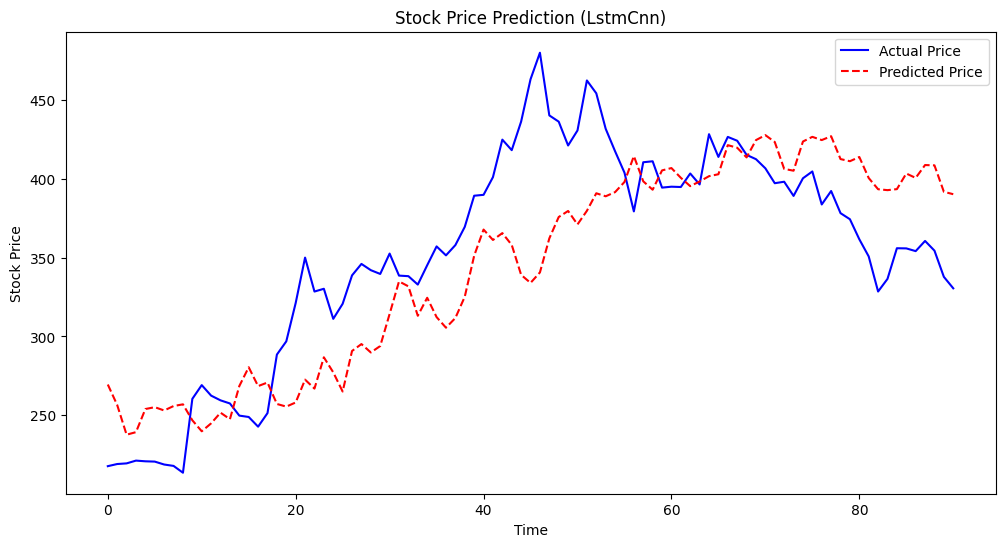


🎯 LstmCnn Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
model_folder = "LstmCnn"
os.makedirs(model_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_model(hp):
    """Builds an LSTM + CNN model with hyperparameter tuning."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [32, 64, 128]), kernel_size=3, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # LSTM Branch
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

    # Merge CNN and LSTM branches
    merged = Concatenate()([cnn, lstm])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=15,  # More trials for better tuning
    executions_per_trial=3,  # More executions for stability
    directory=os.path.join(model_folder, "tuning"),
    project_name="stock_prediction_LstmCnn"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(model_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {model_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 16  # Keep batch size small for better weight updates

# === Step 3: Train the Best Model with Early Stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(model_folder, "best_lstm_cnn_model.keras"))
print(f"✅ Best LSTM + CNN Model saved in {model_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({model_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {model_folder} Model Training & Prediction Complete! 🚀")


✅ Data Loaded: X_train shape: (360, 30, 14), y_train shape: (360, 1)
✅ X_test shape: (91, 30, 14), y_test shape: (91, 1)
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0367 - mae: 0.1467 - val_loss: 0.0733 - val_mae: 0.2414
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0073 - mae: 0.0669 - val_loss: 0.0203 - val_mae: 0.1226
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0063 - mae: 0.0636 - val_loss: 0.0289 - val_mae: 0.1517
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0039 - mae: 0.0498 - val_loss: 0.0287 - val_mae: 0.1514
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0039 - mae: 0.0483 - val_loss: 0.0304 - val_mae: 0.1553
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0036 - mae: 0.0471 - val_loss: 0.0219 - val_mae: 0.1316
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0216 - val_mae: 0.1253
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step -

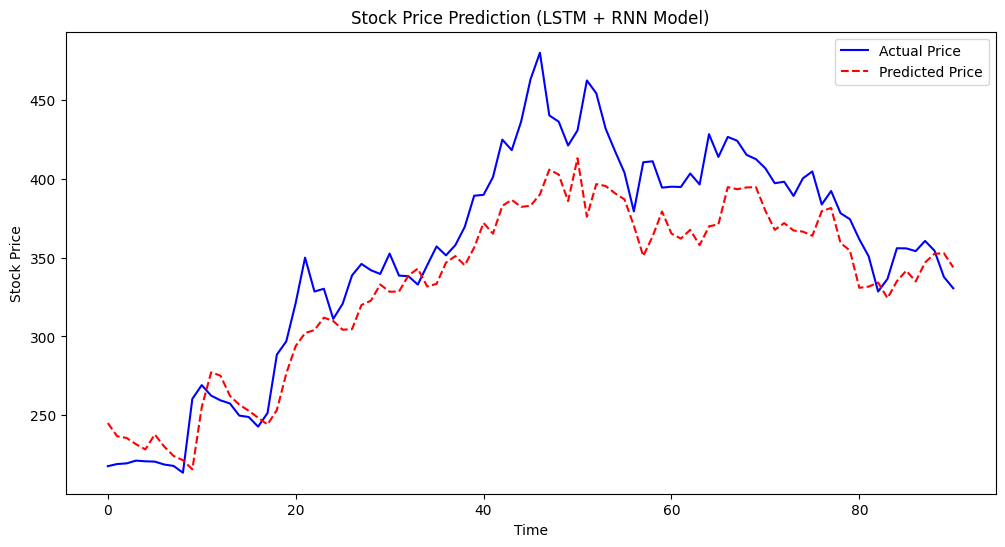


🎯 LSTM + RNN Model Training & Prediction Complete! 🚀


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import os
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# === Define Model Save Path ===
lstm_rnn_folder = "LSTM_RNN_Model"
os.makedirs(lstm_rnn_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load Scaler
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Build and Train Model ===
def build_model():
    """Builds an LSTM + RNN model."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # RNN Branch
    rnn = SimpleRNN(units=75, return_sequences=True)(inputs)
    rnn = SimpleRNN(units=75)(rnn)

    # LSTM Branch
    lstm = LSTM(units=75, return_sequences=True)(inputs)
    lstm = LSTM(units=75)(lstm)

    # Merge RNN and LSTM branches
    merged = Concatenate()([rnn, lstm])
    merged = Dense(50, activation="relu")(merged)
    merged = Dropout(0.2)(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = build_model()
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# ✅ Save the Best Model
model.save(os.path.join(lstm_rnn_folder, "best_lstm_rnn_model.keras"))
print(f"✅ Best LSTM + RNN Model saved in {lstm_rnn_folder}!")

# ✅ Save Best Hyperparameters
best_hyperparameters = {
    "rnn_units": 75,
    "lstm_units": 75,
    "dropout_rate": 0.2,
    "learning_rate": 0.0005
}
with open(os.path.join(lstm_rnn_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hyperparameters, f)
print(f"✅ Best hyperparameters saved in {lstm_rnn_folder}!")

# === Step 3: Evaluate the Model ===
loss, mae = model.evaluate(X_test, y_test)
print(f"✅ Model Test Loss: {loss}")
print(f"✅ Model Test MAE: {mae}")

# === Step 4: Make Predictions ===
predictions = model.predict(X_test)

# === Step 5: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms predictions and actual values using the original scaler."""
    data = np.array(data).reshape(-1, 1)  # Ensure proper reshaping for inverse transformation
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 6: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title("Stock Price Prediction (LSTM + RNN Model)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print("\n🎯 LSTM + RNN Model Training & Prediction Complete! 🚀")


✅ Data Loaded: X_train shape: (360, 30, 14), y_train shape: (360, 1)
✅ X_test shape: (91, 30, 14), y_test shape: (91, 1)
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0393 - mae: 0.1457 - val_loss: 0.0166 - val_mae: 0.1120
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0045 - mae: 0.0510 - val_loss: 0.0186 - val_mae: 0.1161
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0032 - mae: 0.0431 - val_loss: 0.0184 - val_mae: 0.1142
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0030 - mae: 0.0420 - val_loss: 0.0124 - val_mae: 0.0932
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032 - mae: 0.0456 - val_loss: 0.0192 - val_mae: 0.1180
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032 - mae: 0.0431 - val_loss: 0.0220 - val_mae: 0.1226
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0035 - mae: 0.0453 - val_loss: 0.0180 - val_mae: 0.1142
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step -

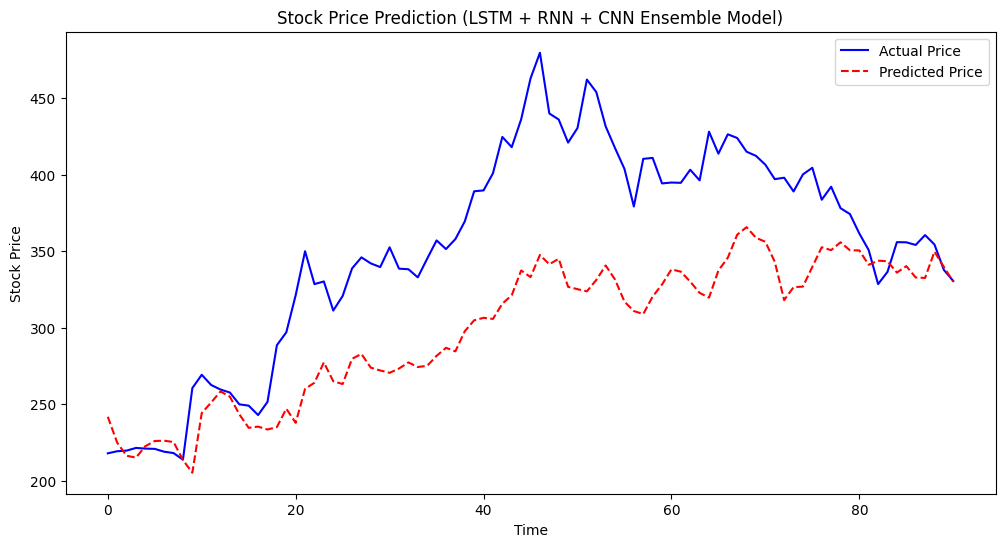


🎯 Ensemble Model Training & Prediction Complete! 🚀


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import os
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Conv1D, Dense, Dropout, Flatten, Concatenate, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel0"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load Scaler
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Build and Train Model ===
def build_model():
    """Builds an Ensemble Model with CNN, RNN, and LSTM."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=75, return_sequences=True)(inputs)
    rnn = SimpleRNN(units=75)(rnn)

    # LSTM Branch
    lstm = LSTM(units=75, return_sequences=True)(inputs)
    lstm = LSTM(units=75)(lstm)

    # Merge all branches
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(50, activation="relu")(merged)
    merged = Dropout(0.2)(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Train Model
model = build_model()
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# ✅ Save the Best Model
model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# ✅ Save Best Hyperparameters
best_hyperparameters = {
    "cnn_filters": 64,
    "rnn_units": 75,
    "lstm_units": 75,
    "dropout_rate": 0.2,
    "learning_rate": 0.0005
}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hyperparameters, f)
print(f"✅ Best hyperparameters saved in {ensemble_folder}!")

# === Step 3: Evaluate the Model ===
loss, mae = model.evaluate(X_test, y_test)
print(f"✅ Model Test Loss: {loss}")
print(f"✅ Model Test MAE: {mae}")

# === Step 4: Make Predictions ===
predictions = model.predict(X_test)

# === Step 5: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms predictions and actual values using the original scaler."""
    data = np.array(data).reshape(-1, 1)  # Ensure proper reshaping for inverse transformation
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 6: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title("Stock Price Prediction (LSTM + RNN + CNN Ensemble Model)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print("\n🎯 Ensemble Model Training & Prediction Complete! 🚀")


ENSEMBLE MODEL FROM BEST CNN RNN AND LSTM

The first ensemble model combines CNN, RNN, and LSTM architectures in a straightforward manner, concatenating their outputs before passing them through dense layers. It uses basic hyperparameter tuning and an early stopping mechanism to optimize training but does not include adaptive weighting. The model focuses on leveraging different feature extraction capabilities of each architecture without dynamically adjusting their contributions.

Trial 15 Complete [00h 02m 24s]
val_loss: 0.018323293887078762

Best val_loss So Far: 0.012001493945717812
Total elapsed time: 00h 34m 51s
✅ Best hyperparameters saved in EnsembleModel!
Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0337 - mae: 0.1444 - val_loss: 0.0182 - val_mae: 0.1077
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0039 - mae: 0.0486 - val_loss: 0.0220 - val_mae: 0.1217
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0028 - mae: 0.0417 - val_loss: 0.0247 - val_mae: 0.1272
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0027 - mae: 0.0394 - val_loss: 0.0147 - val_mae: 0.0989
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0031 - mae: 0.0433 - val_loss: 0.0261 - val_mae: 0.1334
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0023 - mae: 0.0370 - val_loss: 0.0186 - val_mae: 0.1118
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0018 - mae: 0.0339 - val_loss: 0.0180 - val_

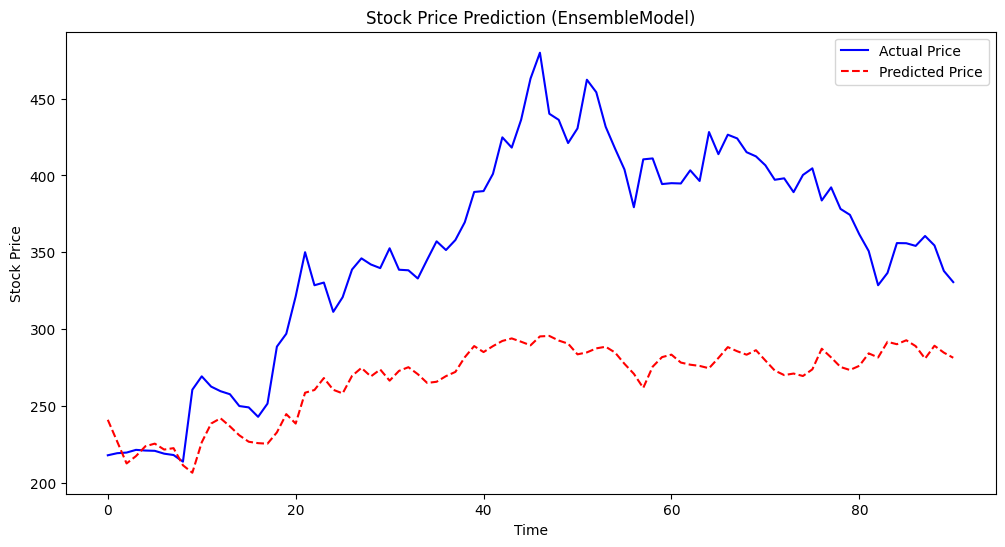


🎯 EnsembleModel Model Training & Prediction Complete! 🚀


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an Ensemble Model combining CNN, RNN, and LSTM branches."""

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]), kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]), activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]))(rnn)

    # LSTM Branch
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

    # Merge CNN, RNN, and LSTM branches
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_ensemble_model,
    objective="val_loss",
    max_trials=15,  # More trials for better tuning
    executions_per_trial=3,  # More executions for stability
    directory=os.path.join(ensemble_folder, "tuning"),
    project_name="stock_prediction_ensemble"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {ensemble_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 16  # Keep batch size small for better weight updates

# === Step 3: Train the Best Model with Early Stopping ===
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,  # No early stopping to ensure full training
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({ensemble_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {ensemble_folder} Model Training & Prediction Complete! 🚀")


This version introduces trainable fusion weights, allowing the model to dynamically adjust the importance of CNN, RNN, and LSTM outputs. It includes Batch Normalization for better gradient flow and Bidirectional layers to improve sequence modeling. Additionally, it replaces early stopping with longer training cycles and cyclical learning rate adjustments, allowing the model to better generalize over time.



Trial 15 Complete [00h 02m 39s]
val_loss: 0.03385528735816479

Best val_loss So Far: 0.015982923408349354
Total elapsed time: 00h 39m 32s
✅ Best hyperparameters saved in EnsembleModel2!
Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.2454 - mae: 0.3293 - val_loss: 0.0612 - val_mae: 0.2034 - learning_rate: 5.0000e-04
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0125 - mae: 0.0917 - val_loss: 0.1384 - val_mae: 0.3319 - learning_rate: 5.0000e-04
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0068 - mae: 0.0691 - val_loss: 0.0835 - val_mae: 0.2558 - learning_rate: 5.0000e-04
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0048 - mae: 0.0542 - val_loss: 0.0615 - val_mae: 0.2190 - learning_rate: 5.0000e-04
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0043 - mae: 0.0501 - val_loss: 0.0574 - val_mae: 0.2123 - learning_rate: 5.0000e-04
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0033 - mae: 0.0453 - v

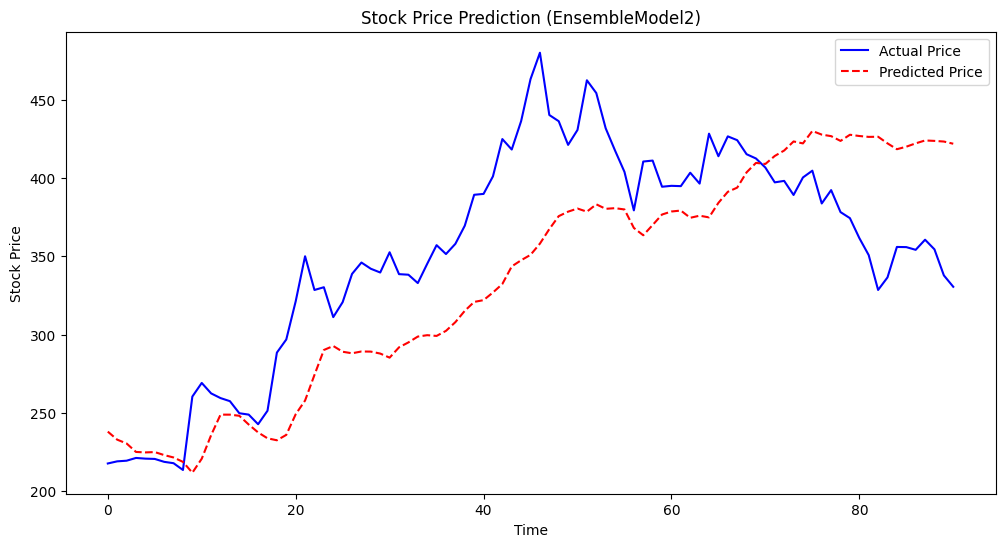


🎯 EnsembleModel2 Model Training & Prediction Complete! 🚀


In [21]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, Multiply, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel2"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an improved Ensemble Model combining CNN, RNN, and LSTM with Attention and Adaptive Weighted Fusion."""
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # === CNN Branch ===
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]),
                 kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]),
                 activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn_weight = Dense(1, activation='sigmoid')(cnn)  # Adaptive weighting

    # === RNN Branch ===
    rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]), return_sequences=True)(rnn)
    rnn = Attention()([rnn, rnn])
    rnn = Flatten()(rnn)
    rnn_weight = Dense(1, activation='sigmoid')(rnn)  # Adaptive weighting

    # === LSTM Branch ===
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]), return_sequences=True)(lstm)
    lstm = Attention()([lstm, lstm])
    lstm = Flatten()(lstm)
    lstm_weight = Dense(1, activation='sigmoid')(lstm)  # Adaptive weighting

    # === Adaptive Weighted Fusion ===
    cnn_scaled = Multiply()([cnn, cnn_weight])
    rnn_scaled = Multiply()([rnn, rnn_weight])
    lstm_scaled = Multiply()([lstm, lstm_weight])

    merged = Concatenate()([cnn_scaled, rnn_scaled, lstm_scaled])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_ensemble_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=3,
    directory=os.path.join(ensemble_folder, "tuning"),
    project_name="stock_prediction_ensemble"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {ensemble_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 32  # Increased batch size for improved training

# === Step 3: Train the Best Model with Learning Rate Decay ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({ensemble_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {ensemble_folder} Model Training & Prediction Complete! 🚀")


The most advanced version incorporates trainable ReLU-based fusion weights normalized by Softmax, ensuring a more balanced contribution from CNN, RNN, and LSTM branches. It also replaces Adam with the rmsprop optimizer, which provides better convergence, and uses Layer Normalization for more stable training. The model benefits from increased architectural depth, global average pooling, and improved dropout strategies, leading to greater adaptability in stock price prediction. 🚀

Trial 15 Complete [00h 02m 31s]
val_loss: 0.00939560386662682

Best val_loss So Far: 0.00939560386662682
Total elapsed time: 00h 37m 25s
✅ Best hyperparameters saved in EnsembleModel3!
Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.3322 - mae: 0.3079 - val_loss: 0.0522 - val_mae: 0.1908
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0096 - mae: 0.0799 - val_loss: 0.0278 - val_mae: 0.1369
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0087 - mae: 0.0778 - val_loss: 0.0565 - val_mae: 0.2075
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0046 - mae: 0.0538 - val_loss: 0.0378 - val_mae: 0.1669
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0043 - mae: 0.0526 - val_loss: 0.0205 - val_mae: 0.1217
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0066 - mae: 0.0642 - val_loss: 0.0427 - val_mae: 0.1809
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - mae: 0.0364 - val_loss: 0.0566 - val_m

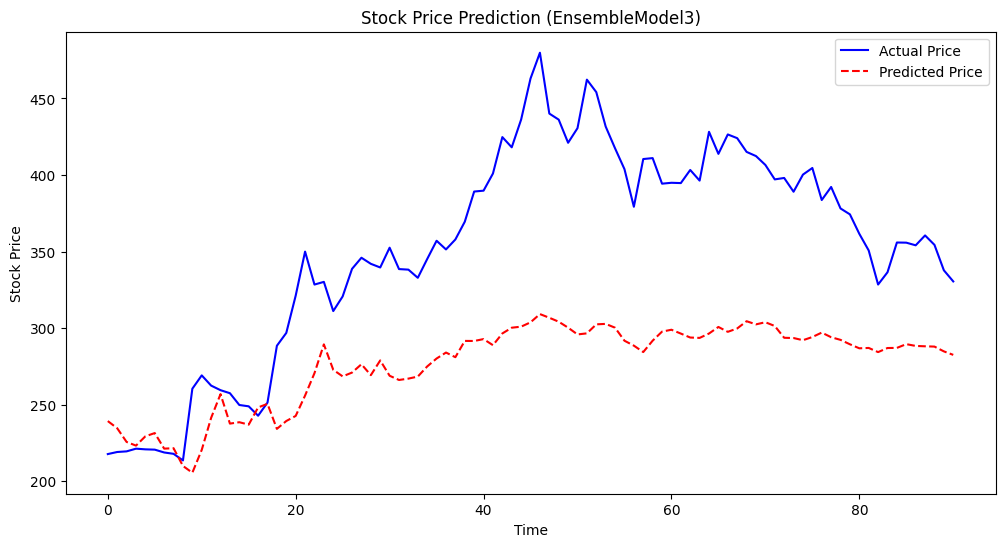


🎯 EnsembleModel3 Model Training & Prediction Complete! 🚀


In [22]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# === Define Model Save Path ===
ensemble_folder = "EnsembleModel3"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Preprocessed Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Load the correct scaler for stock prices
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Hyperparameter Tuning ===
def build_ensemble_model(hp):
    """Builds an Ensemble Model combining CNN, RNN, and LSTM branches."""

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]), kernel_size=hp.Choice('cnn_kernel_size', [3, 5, 7]), activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
    rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]))(rnn)

    # LSTM Branch
    lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
    lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]))(lstm)

    # Merge CNN, RNN, and LSTM branches
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
    merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

    # Output Layer
    output = Dense(1)(merged)

    # Compile Model
    model = Model(inputs, output)
    model.compile(
        optimizer=RMSprop(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ✅ Run Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_ensemble_model,
    objective="val_loss",
    max_trials=15,  # More trials for better tuning
    executions_per_trial=3,  # More executions for stability
    directory=os.path.join(ensemble_folder, "tuning"),
    project_name="stock_prediction_ensemble"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

# ✅ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# ✅ Save Best Hyperparameters
best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
with open(os.path.join(ensemble_folder, "best_hyperparameters.json"), "w") as f:
    json.dump(best_hps_dict, f)
print(f"✅ Best hyperparameters saved in {ensemble_folder}!")

# ✅ Set Batch Size
BATCH_SIZE = 16  # Keep batch size small for better weight updates

# === Step 3: Train the Best Model ===
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,  # No early stopping to ensure full training
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

# ✅ Save the Best Model
best_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# === Step 4: Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Step 5: Make Predictions ===
predictions = best_model.predict(X_test)

# === Step 6: Reverse Scale Predictions and Actual Values ===
def inverse_transform_single_feature(scaler, data):
    """Properly inverse transforms a single feature using the original scaler."""
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)

# ✅ Rescale Predictions and Actual Prices
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Step 7: Plot Predicted vs. Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction ({ensemble_folder})")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"\n🎯 {ensemble_folder} Model Training & Prediction Complete! 🚀")


Hybrid model + Arimia??? is this a bad idea??? we'll see

✅ Data Loaded: X_train shape: (360, 30, 14), y_train shape: (360,)
✅ X_test shape: (91, 30, 14), y_test shape: (91,)
✅ Best ARIMA Model saved in EnsembleModelARIMA!


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0643 - mae: 0.1932 - val_loss: 0.0646 - val_mae: 0.2279
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0061 - mae: 0.0646 - val_loss: 0.0339 - val_mae: 0.1533
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0027 - mae: 0.0402 - val_loss: 0.0394 - val_mae: 0.1676
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - mae: 0.0375 - val_loss: 0.0233 - val_mae: 0.1253
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - mae: 0.0393 - val_loss: 0.0309 - val_mae: 0.1460
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020 - mae: 0.0338 - val_loss: 0.0229 - val_mae: 0.1241
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0023 - mae: 0.0378 - val_loss: 0.0202 - val_mae: 0.1168
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - mae: 0.0335 - val_loss: 0.0179 - val_mae: 0.1085
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - lo

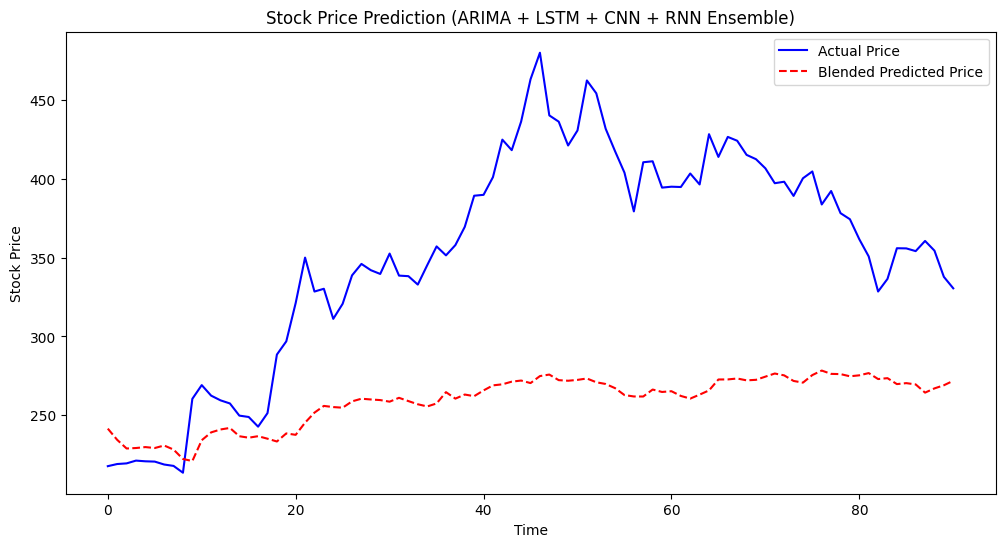


🎯 ARIMA + Deep Learning Ensemble Model Complete! 🚀


In [23]:
import os
import numpy as np
import tensorflow as tf
import joblib
import json
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Define Model Save Path ===
ensemble_folder = "EnsembleModelARIMA"
os.makedirs(ensemble_folder, exist_ok=True)

# === Step 1: Load Data ===
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy").flatten()
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy").flatten()

# Load Scaler
scaler_y = joblib.load("scaler_y.pkl")

print(f"✅ Data Loaded: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# === Step 2: Train ARIMA Model Separately ===
best_p, best_d, best_q = (3, 1, 2)  # Use your best ARIMA hyperparameters
arima_model = ARIMA(y_train, order=(best_p, best_d, best_q))
arima_fit = arima_model.fit()

# ✅ Save ARIMA Model
joblib.dump(arima_fit, os.path.join(ensemble_folder, "best_arima_model.pkl"))
print(f"✅ Best ARIMA Model saved in {ensemble_folder}!")

# Predict with ARIMA
arima_predictions = arima_fit.forecast(steps=len(y_test))
arima_predictions_rescaled = scaler_y.inverse_transform(arima_predictions.reshape(-1, 1)).flatten()

# === Step 3: Define Deep Learning Ensemble Model ===
def build_ensemble_model():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # CNN Branch
    cnn = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # RNN Branch
    rnn = SimpleRNN(units=100, return_sequences=True)(inputs)
    rnn = SimpleRNN(units=75)(rnn)

    # LSTM Branch
    lstm = LSTM(units=75, return_sequences=True)(inputs)
    lstm = LSTM(units=50)(lstm)

    # Merge Deep Learning Predictions
    merged = Concatenate()([cnn, rnn, lstm])
    merged = Dense(100, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    output = Dense(1)(merged)

    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

# ✅ Train Deep Learning Ensemble
ensemble_model = build_ensemble_model()
history = ensemble_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ✅ Save Model
ensemble_model.save(os.path.join(ensemble_folder, "best_ensemble_model.keras"))
print(f"✅ Best Ensemble Model saved in {ensemble_folder}!")

# Predict with Ensemble
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_predictions_rescaled = scaler_y.inverse_transform(ensemble_predictions)

# === Step 4: Final Blended Prediction (Averaging) ===
final_predictions = (arima_predictions_rescaled + ensemble_predictions_rescaled.flatten()) / 2

# === Step 5: Evaluate Performance ===
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
print(f"✅ Blended Model MAE: {mae:.4f}, MSE: {mse:.4f}")

# === Step 6: Plot Results ===
plt.figure(figsize=(12, 6))
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), label="Actual Price", color="blue")
plt.plot(final_predictions, label="Blended Predicted Price", color="red", linestyle="dashed")
plt.title("Stock Price Prediction (ARIMA + LSTM + CNN + RNN Ensemble)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print("\n🎯 ARIMA + Deep Learning Ensemble Model Complete! 🚀")
